# **Data Understanding and Visualization**
## **Load and Visualize Images**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


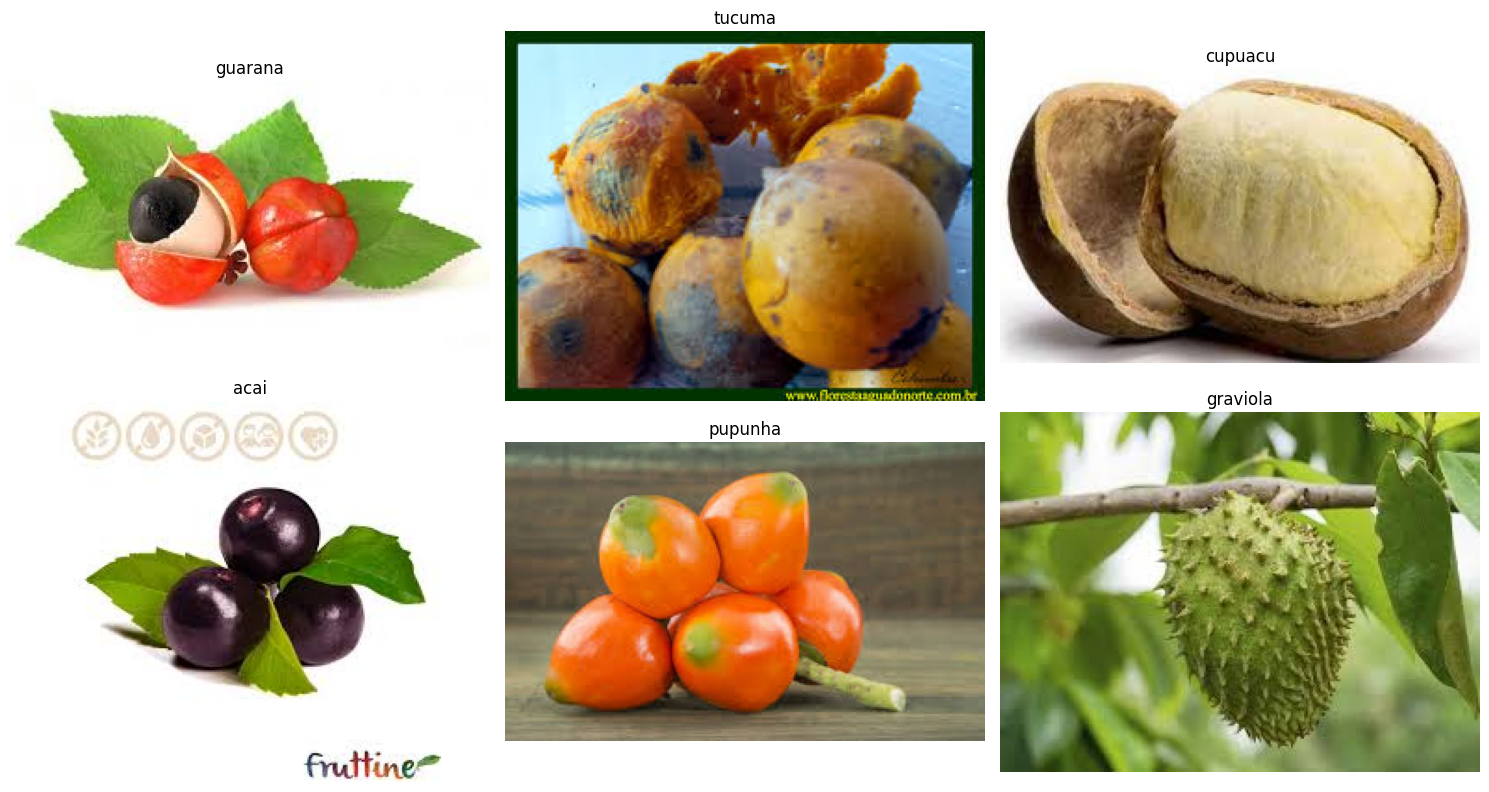

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to the train directory
train_dir = "/content/drive/MyDrive/AI and ML/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI and ML/FruitinAmazon/test"

# Get the list of class directories
class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Function to load and display images
def visualize_images(class_dirs, num_images_per_class=1):
    fig, axes = plt.subplots(2, len(class_dirs) // 2, figsize=(15, 8))
    axes = axes.flatten()

    for i, class_dir in enumerate(class_dirs):
        # Get all image files in the class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
        # Randomly select an image
        selected_image = random.choice(image_files)
        image_path = os.path.join(class_dir, selected_image)

        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(os.path.basename(class_dir))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
visualize_images(class_dirs)

## **Check for Corrupted Images**

In [4]:
def check_corrupted_images(directory):
    corrupted_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    print(f"Removed corrupted image: {file_path}")
                    corrupted_images.append(file_path)
                    os.remove(file_path)
    if not corrupted_images:
        print("No corrupted images found.")

check_corrupted_images(train_dir)

No corrupted images found.


# **Loading and Preprocessing Image Data in Keras**

In [5]:
import tensorflow as tf

# Define image size and batch size
img_height, img_width = 128, 128
batch_size = 16
validation_split = 0.2

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load and preprocess test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    seed=123
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))



Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 30 files belonging to 6 classes.


In [6]:
for class_dir in class_dirs:
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
    if len(image_files) == 0:
        print(f"Empty directory: {class_dir}")

# **Implement a CNN**

In [7]:
import tensorflow as tf

num_classes = len(os.listdir(train_dir))

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,222 (16.07 MB)

 Trainable params: 4,213,222 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

# **Compile the Model**

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# **Train the Model**

In [10]:
import tensorflow as tf

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    train_ds,
    epochs=250,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.1743 - loss: 3.1235
Epoch 1: val_loss improved from inf to 1.85997, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1707 - loss: 3.1253 - val_accuracy: 0.1000 - val_loss: 1.8600
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.1948 - loss: 1.8079
Epoch 2: val_loss improved from 1.85997 to 1.68055, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.1970 - loss: 1.7997 - val_accuracy: 0.5000 - val_loss: 1.6805
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7163 - loss: 1.6452
Epoch 3: val_loss improved from 1.68055 to 1.59557, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.7173 - loss: 1.6415 - val_accuracy: 0.3333 - val_loss: 1.5956
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5983 - loss: 1.4104
Epoch 4: val_loss improved from 1.59557 to 1.30947, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - accuracy: 0.6004 - loss: 1.4006 - val_accuracy: 0.5000 - val_loss: 1.3095
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.6642 - loss: 0.9964
Epoch 5: val_loss improved from 1.30947 to 1.14043, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - accuracy: 0.6670 - loss: 0.9901 - val_accuracy: 0.5000 - val_loss: 1.1404
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7983 - loss: 0.6718
Epoch 6: val_loss did not improve from 1.14043
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.7948 - loss: 0.6705 - val_accuracy: 0.5333 - val_loss: 1.5560
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8535 - loss: 0.5303
Epoch 7: val_loss improved from 1.14043 to 0.94567, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.8478 - loss: 0.5398 - val_accuracy: 0.5333 - val_loss: 0.9457
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8993 - loss: 0.3844
Epoch 8: val_loss did not improve from 0.94567
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.8929 - loss: 0.3929 - val_accuracy: 0.5667 - val_loss: 1.0470
Epoch 9/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9677 - loss: 0.2454
Epoch 9: val_loss did not improve from 0.94567
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.9661 - loss: 0.2514 - val_accuracy: 0.5667 - val_loss: 1.0484
Epoch 10/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9837 - loss: 0.1466
Epoch 10: val_loss improved from 0.94567 to 0.66716, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.9841 - loss: 0.1458 - val_accuracy: 0.7333 - val_loss: 0.6672
Epoch 11/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 1.0000 - loss: 0.0710
Epoch 11: val_loss did not improve from 0.66716
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 1.0000 - loss: 0.0678 - val_accuracy: 0.6667 - val_loss: 0.9745
Epoch 12/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9712 - loss: 0.0446
Epoch 12: val_loss did not improve from 0.66716
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.9737 - loss: 0.0434 - val_accuracy: 0.7000 - val_loss: 0.9242
Epoch 13/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 1.0000 - loss: 0.0115
Epoch 13: val_loss did not improve from 0.66716
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.6667 - val_loss: 0.9208
Epoch 14/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 1.0000 - loss: 0.0070
Epoch 14: val_loss did not improve from 0.66716
5/5 

# **Evaluate the Model**

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7806 - loss: 0.5962
Test accuracy: 0.7333


# **Save and Load the Model**

In [12]:
# Save the model
model.save("final_model.h5")

# Load the saved model
loaded_model = tf.keras.models.load_model("final_model.h5")

# Re-evaluate the loaded model
test_loss_loaded, test_acc_loaded = loaded_model.evaluate(test_ds)
print(f"Loaded Model Test accuracy: {test_acc_loaded:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7806 - loss: 0.5962
Loaded Model Test accuracy: 0.7333


# **Predictions and Classification Report**

In [13]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = os.listdir(train_dir)
print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
              precision    recall  f1-score   support

     guarana       0.83      1.00      0.91         5
      tucuma       0.60      0.60      0.60         5
     cupuacu       0.62      1.00      0.77         5
        acai       0.80      0.80      0.80         5
     pupunha       0.80      0.80      0.80         5
    graviola       1.00      0.20      0.33         5

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.70        30
weighted avg       0.78      0.73      0.70        30



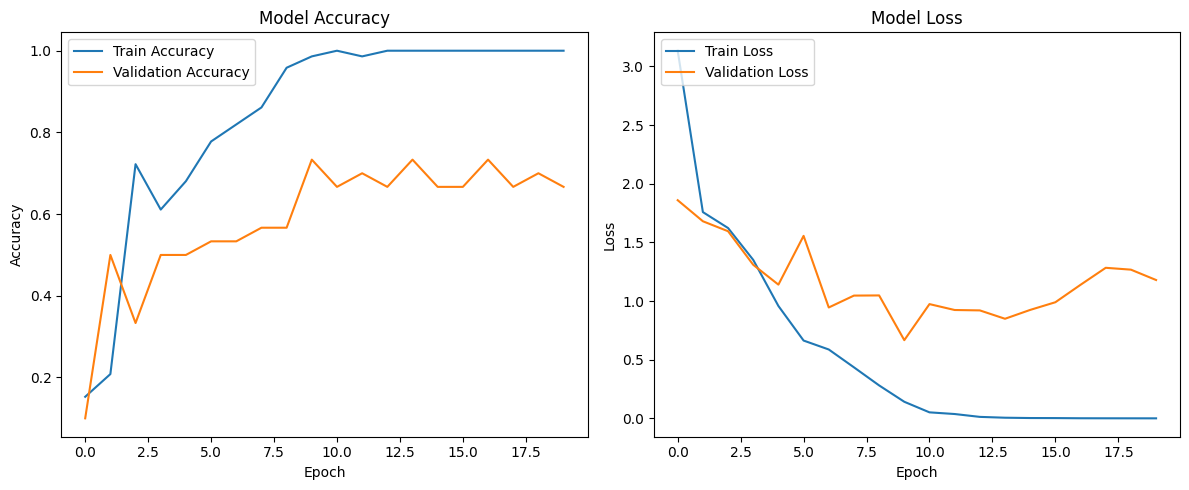

In [14]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to visualize training history
plot_training_history(history)